In [ ]:
#!pip install keras
#!pip install tensorflow

In [ ]:
#!pip install scikeras

In [ ]:
# importing the libraries
import numpy as np
import seaborn as sns
from PIL import Image
import os

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!unzip /content/CovidXRayImages.zip -d CovidXRayImages

Streaming output truncated to the last 5000 lines.
  inflating: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10838).png  
  inflating: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10839).png  
  inflating: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10840).png  
  inflating: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10841).png  
 extracting: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10843).png  
  inflating: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10844).png  
  inflating: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10845).png  
  inflating: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10846).png  
  inflating: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10847).png  
 extracting: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10848).png  
  inflating: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10849).png  
  inflating: CovidXRayImages/Val/Non-COVID/lung masks/non_COVID (10850).png  
 extracting: 

In [ ]:
def load_and_preprocess_images(base_path, target_size=(64, 64)):
    images = []
    labels = []
    label_mapping = {'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}

    for label in os.listdir(base_path):
        class_path = os.path.join(base_path, label)
        # Skip any non-directory entries in the base_path
        if not os.path.isdir(class_path):
            continue
        for subdir in os.listdir(class_path):
            subdir_path = os.path.join(class_path, subdir)
            # Check if the entry is a directory and skip if not
            if not os.path.isdir(subdir_path):
                continue
            for img_name in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, img_name)
                # Check if the entry is a file before attempting to open
                if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        with Image.open(img_path) as img:
                            # Resize the image
                            img_resized = img.resize(target_size)
                            # Normalize pixel values to be between 0 and 1
                            img_array = np.array(img_resized) / 255.0
                            images.append(img_array)
                            labels.append(label_mapping[label])
                    except Exception as e:
                        print(f"Could not load image {img_path}: {e}")

    return np.array(images), np.array(labels)

# Assuming the dataset is structured correctly under './CovidXRayImages/Val'
base_path = './CovidXRayImages/Val'
images, labels = load_and_preprocess_images(base_path)

In [ ]:
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (10834, 64, 64)
Labels shape: (10834,)


In [ ]:
# Splitting the dataset into training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(images, labels, train_size=0.7, random_state=42, stratify=labels)

# Splitting the remaining dataset into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

In [ ]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_val_flattened = X_val.reshape(X_val.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# dnn model architecture
model = Sequential([
    Flatten(input_shape=(4096,)),
    Dense(512, activation='relu'),  #hidden layer1
    Dropout(0.4),
    Dense(256, activation='relu'),  #hidden layer2
    Dropout(0.4),
    Dense(128, activation='relu'),  #hidden layer3
    Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',    #optimizer
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
earlystop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True)

In [ ]:
model.fit(
    X_train_flattened,
    y_train,
    epochs=100,
    batch_size=30,
    validation_data=(X_val_flattened, y_val),
    callbacks=[earlystop]
)

Epoch 1/100
253/253 [==============================] - 13s 46ms/step - loss: 1.1711 - accuracy: 0.4034 - val_loss: 1.0313 - val_accuracy: 0.4572
Epoch 2/100
253/253 [==============================] - 11s 42ms/step - loss: 1.0170 - accuracy: 0.4813 - val_loss: 0.9637 - val_accuracy: 0.4917
Epoch 3/100
253/253 [==============================] - 11s 42ms/step - loss: 0.9860 - accuracy: 0.5111 - val_loss: 0.9402 - val_accuracy: 0.5483
Epoch 4/100
253/253 [==============================] - 11s 42ms/step - loss: 0.9915 - accuracy: 0.5007 - val_loss: 0.9476 - val_accuracy: 0.5323
Epoch 5/100
253/253 [==============================] - 16s 62ms/step - loss: 0.9634 - accuracy: 0.5392 - val_loss: 0.9354 - val_accuracy: 0.5508
Epoch 6/100
253/253 [==============================] - 19s 76ms/step - loss: 0.9668 - accuracy: 0.5288 - val_loss: 0.9246 - val_accuracy: 0.5778
Epoch 7/100
253/253 [==============================] - 11s 42ms/step - loss: 0.9463 - accuracy: 0.5481 - val_loss: 0.9235 - val_ac

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train_flattened, y_train)
test_loss, test_accuracy = model.evaluate(X_val_flattened, y_val)
print(f'Train Accuracy :- {round(train_accuracy, 4) * 100} %')
print(f'Test Accuracy :- {round(test_accuracy, 4) * 100} %')

51/51 [==============================] - 0s 7ms/step - loss: 0.8687 - accuracy: 0.6043
Train Accuracy :- 69.37 %
Test Accuracy :- 60.42999999999999 %


In [ ]:
y_pred = model.predict(X_test_flattened)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

51/51 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.55      0.73      0.63       571
           1       0.70      0.52      0.59       541
           2       0.67      0.61      0.64       514

    accuracy                           0.62      1626
   macro avg       0.64      0.62      0.62      1626
weighted avg       0.64      0.62      0.62      1626



<Axes: >

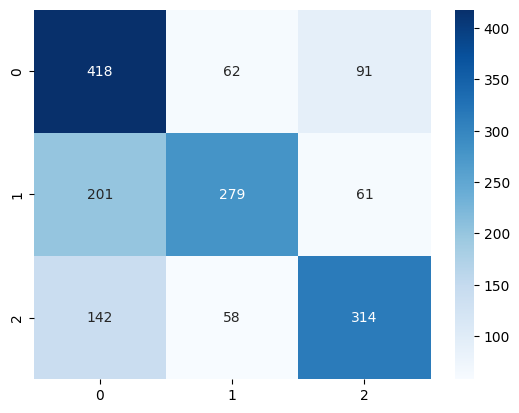

In [ ]:
cm = confusion_matrix(y_test, y_pred)
labels = {'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}
sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues", xticklabels=labels.values(), yticklabels=labels.values())

In [ ]:
!pip install scikeras


In [ ]:

from scikeras.wrappers import KerasClassifier

#from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
def dnn_model():
    model = Sequential([
        Flatten(input_shape=(4096,)),
        Dense(512, activation='relu'),  #hidden layer1
        Dropout(0.4),
        Dense(256, activation='relu'),  #hidden layer2
        Dropout(0.4),
        Dense(128, activation='relu'),  #hidden layer3
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    return model

dnnmodel = KerasClassifier(build_fn=dnn_model, epochs=100, batch_size=30, verbose=0)
kf = KFold(n_splits=4, shuffle=True)
cvs = cross_val_score(dnnmodel, X_train_flattened, y_train, cv = kf)
print(f'Average Accuracy : {cvs.mean()*100} \n Stanadard Deviation : {cvs.std()}')

Average Accuracy : 60.173765349632056 
 Stanadard Deviation : 0.018345101982562527


Model Expalainer(Lime)


In [ ]:
#!pip install lime#!pip install scikit-image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import lime
import lime.lime_image

from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
import numpy as np
import skimage.segmentation

In [ ]:
#!pip install tensorflow


In [ ]:
import os
import lime
import lime.lime_image
import numpy as np
from PIL import Image
import random
from skimage.io import imread
import matplotlib.pyplot as plt


#creating explaimer from lime

explainer = lime.lime_image.LimeImageExplainer()

#giving covid images file path

covid_images_path = "/content/CovidXRayImages/Val/COVID-19/images"
covid_image_paths = [os.path.join(covid_images_path, img_name) for img_name in os.listdir(covid_images_path)]

# Chooseing a random image
random_image_path = random.choice(covid_image_paths)

def load_and_preprocess_single_image(img_path):
    image = Image.open(img_path)
    # Resizing the image to match the model's input size as was facing error with explation function
    image_resized = image.resize((64, 64))
    # Converting image to numpy array and normalize pixel values
    image_array = np.array(image_resized) / 255.0
    return image_array

# Loading and random image
random_image = load_and_preprocess_single_image(random_image_path)

# Reshaped  image according to the  LIME explainer
random_image_reshaped = random_image.reshape(1, -1)

# creating  a dummy predict function
def predict_fn(images):
    # Return dummy predictions for explanation
    return np.random.rand(images.shape[0], 3)

# Taking 200   samples for explanation
num_samples = 200

# Explaining the instance using
explanation = explainer.explain_instance(random_image_reshaped, predict_fn, top_labels=3, hide_color=0, num_samples=num_samples)

# Ploting the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)



  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
print(explanation)


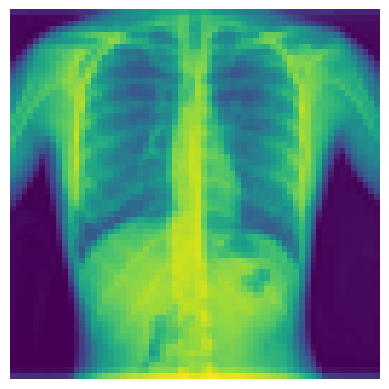

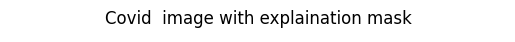

In [ ]:
# Display the original image
plt.imshow(random_image)

plt.axis('off')
plt.show()

# Display the explanation image with mask
plt.imshow(explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)[0])
plt.title('Covid  image with explaination mask')
plt.axis('off')
plt.show()


In [ ]:



# giving path for normal images images

normal_images_path = "/content/CovidXRayImages/Val/Normal/images"
normal_image_paths = [os.path.join(normal_images_path, img_name) for img_name in os.listdir(normal_images_path)]


# choosing r a random image from normal xrays
random_image_path = random.choice(normal_image_paths)

def load_and_preprocess_single_image(img_path):
    image = Image.open(img_path)

    image_resized = image.resize((64, 64))

    image_array = np.array(image_resized) / 255.0
    return image_array

# choosing 1 image
random_image = load_and_preprocess_single_image(random_image_path)

# Reshaping the image
random_image_reshaped = random_image.reshape(1, -1)


def predict_fn(images):


    return np.random.rand(images.shape[0], 3)

# taking 200 no. of samples for explanation
num_samples = 200
#creating a variable for the explaination

explanation = explainer.explain_instance(random_image_reshaped, predict_fn, top_labels=3, hide_color=0, num_samples=num_samples)

# Plot the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)



  0%|          | 0/200 [00:00<?, ?it/s]

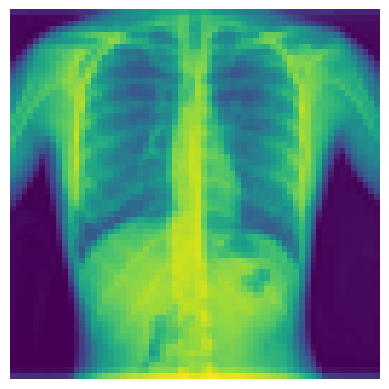

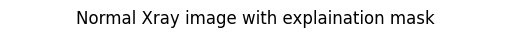

In [ ]:
# ploting  original image
plt.imshow(random_image)
plt.axis('off')
plt.show()

# plotinh the explanation image with mask
plt.imshow(explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)[0])
plt.title('Normal Xray image with explaination mask ')
plt.axis('off')
plt.show()


In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

# Load the Boston House Prices dataset
data = pd.read_csv('boston.csv')

# Split the dataset into features (X) and target variable (y)
X = data.drop(columns=['medv'])
y = data['medv']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the LightGBM regressor model
lgb_model = lgb.LGBMRegressor()

# Train the model on the training data
lgb_model.fit(X_train, y_train)

# Visualize and interpret critical decisions
explainer = shap.Explainer(lgb_model)
shap_values = explainer.shap_values(X_train)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Plot SHAP values for a specific feature
shap.dependence_plot("RM", shap_values, X_train)

# Partial Dependence Plot (PDP)
fig, ax = plt.subplots(figsize=(8, 6))
pdp_feature = 'RM'  # Example: 'RM' is the average number of rooms per dwelling
pdp_data = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(shap_values, columns=X_train.columns)], axis=1)
pdp_data = pdp_data.sample(frac=0.1)  # Sample a subset for faster computation
pdp_data.sort_values(by=pdp_feature, inplace=True)
pdp_feature_values = np.linspace(pdp_data[pdp_feature].min(), pdp_data[pdp_feature].max(), 100)
pdp_means = []
for value in pdp_feature_values:
    pdp_data[pdp_feature] = value
    pdp_pred = lgb_model.predict(pdp_data)
    pdp_means.append(np.mean(pdp_pred))
ax.plot(pdp_feature_values, pdp_means)
ax.set_title(f'Partial Dependence Plot for {pdp_feature}')
ax.set_xlabel(pdp_feature)
ax.set_ylabel('Predicted Price')
plt.show()


ModuleNotFoundError: No module named 'shap'

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

# Load the Boston House Prices dataset
data = pd.read_csv('boston.csv')

# Split the dataset into features (X) and target variable (y)
X = data.drop(columns=['medv'])
y = data['medv']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the LightGBM regressor model
lgb_model = lgb.LGBMRegressor()

# Train the model on the training data
lgb_model.fit(X_train, y_train)

# Visualize and interpret critical decisions
explainer = shap.Explainer(lgb_model)
shap_values = explainer.shap_values(X_train)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Plot SHAP values for a specific feature
shap.dependence_plot("RM", shap_values, X_train)

# Partial Dependence Plot (PDP)
fig, ax = plt.subplots(figsize=(8, 6))
pdp_feature = 'RM'  # Example: 'RM' is the average number of rooms per dwelling
pdp_data = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(shap_values, columns=X_train.columns)], axis=1)
pdp_data = pdp_data.sample(frac=0.1)  # Sample a subset for faster computation
pdp_data.sort_values(by=pdp_feature, inplace=True)
pdp_feature_values = np.linspace(pdp_data[pdp_feature].min(), pdp_data[pdp_feature].max(), 100)
pdp_means = []
for value in pdp_feature_values:
    pdp_data[pdp_feature] = value
    pdp_pred = lgb_model.predict(pdp_data)
    pdp_means.append(np.mean(pdp_pred))
ax.plot(pdp_feature_values, pdp_means)
ax.set_title(f'Partial Dependence Plot for {pdp_feature}')
ax.set_xlabel(pdp_feature)
ax.set_ylabel('Predicted Price')
plt.show()


ModuleNotFoundError: No module named 'shap'